## 1. Importing Relevent Liabraries

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os 
import warnings


import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
init_notebook_mode(connected=True)


%matplotlib inline
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 2.Cleaning and feature selection in the data

In [16]:
df=pd.read_csv("C:\\Users\\balra\\Downloads/movies_data_before_cleaning.csv",encoding = 'latin-1')
df.head()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 4


### 2.1 Cleaning Year column
*Types of values in year column*
1. year only
2. year-
3. year-year
4. (roman) [(year) or (year-year)]
5. (year and some string)


In [4]:
df['YEAR'].unique()

array(['(2021)', '(2021– )', '(2010–2022)', '(2013– )', '(2020– )',
       '(2006–2013)', '(2019– )', '(2016–2021)', '(2011– )', '(2005– )',
       '(2008–2013)', '(2017– )', '(2017–2021)', '(2016– )',
       '(1994–2004)', '(2014– )', '(2013–2020)', '(2015– )',
       '(2005–2020)', '(2013–2022)', '(2003– )', '(2009–2020)',
       '(I) (2018– )', '(2010–2015)', '(2011–2019)', '(2015–2020)',
       '(2005–2014)', '(2009–2015)', '(2008–2014)', '(2016–2018)',
       '(2009–2017)', '(2020)', '(2018–2021)', '(2017–2020)',
       '(1987–1994)', '(2018– )', '(2012– )', '(2014–2020)',
       '(2011–2018)', '(2005–2017)', '(2017)', '(2007–2015)',
       '(2000–2007)', '(II) (2007– )', '(1993)', '(1999–2022)',
       '(2015–2018)', '(2014–2019)', '(2016)', '(2012–2020)',
       '(2013–2019)', '(2007–2012)', '(2011–2020)', '(2010–2017)',
       '(2000–2015)', '(2015–2021)', '(2001)', '(1997– )', '(2011–2017)',
       '(1993–1999)', '(1989–1998)', '(2010–2013)', '(2010–2020)',
       '(2003–2019)

In [5]:
df['YEAR'] = df.YEAR.apply(lambda x: str(str(x).split("(")[-1]).split(")")[0])
years= df.YEAR

## years that end in "-" means that the show is still going,so its better to take this account in order to update it later on to current year.
with_hypen=[]
for i in range(len(years)):
    if years[i][-1]==" ":
        with_hypen.append(1)
    else:
        with_hypen.append(0)
df['hypen_year']=with_hypen

## Getting only the interger values and joining the integere values to create year-like pattern YYYY-YYYY and separating them into differetn columns
def convert(list):
      
    # Converting integer list to string list
    s = [str(i) for i in list]
      
    # Join list items using join()
    res = "".join(s)
      
    return(res)

year=[]
year_1=[]
year_2=[]
for i in range(len(df)):
    a = re.findall("\w\d",df.YEAR[i])
    year.append(convert(a))
    year_1.append(year[i][:4])
    year_2.append(year[i][-4:])
df['YEAR']=year
df['beg_year']=year_1
df['end_year']=year_2

## Converting values to numeric values
df['beg_year']=pd.to_numeric(df['beg_year'])
df['end_year']=pd.to_numeric(df['end_year'])

# updating all end years with - (eg:-2021-) to 2022
hypen=[]
for i in range(len(df)):
    if df['hypen_year'][i]==1:
        hypen.append(2022)
    else:
        hypen.append(df['end_year'][i])
df['end_year']=hypen

df['Num_years']=df['end_year']-df['beg_year']
df.beg_year.fillna(0,inplace=True)
df.end_year.fillna(0,inplace=True)
df.Num_years.fillna(0,inplace=True)

### 2.2 Filling up the missing values 

In [6]:
df['VOTES']=df['VOTES'].str.replace(",","")
df['VOTES']=pd.to_numeric(df['VOTES'])
df['VOTES']=df['VOTES'].fillna(df.VOTES.median())

df['RunTime']=df['RunTime'].fillna(df.RunTime.median())

df['RATING']=df['RATING'].fillna(df.RATING.median())

df['Gross'].fillna("0",inplace=True)


### 2.3 Creating features using genre column 

In [7]:
## Extracting the string values in genre's column

df['GENRE'] = df['GENRE'].apply(lambda x: str(x).split("\n")[-1]) ## to remove "\n" and fetch the value of the genre's

df['GENRE'] = df['GENRE'].str.replace(' ', '') ## There are multiple unncessary spaces in genre 

df.head()


## Counting the number of movies in which each genre is featured

from itertools import combinations
from collections import Counter

count=Counter()

for row in df['GENRE']:
    row_split=row.split(",")
    count.update(Counter(combinations(row_split,1)))
    
count.most_common(10)

[(('Drama',), 4325),
 (('Comedy',), 2832),
 (('Action',), 2258),
 (('Adventure',), 1792),
 (('Animation',), 1732),
 (('Crime',), 1566),
 (('Documentary',), 1224),
 (('Thriller',), 910),
 (('Mystery',), 880),
 (('Romance',), 853)]

In [8]:
## getting all genres in a list format

genre=[]

for i,key in enumerate(count):
    genre.append(str(key).split("(")[-1].split("'")[1]) ## getting rid of unncessary parts of the string

## creating columns for each genre and updating the respecting values

df[genre]=0

for i in range(len(df)):
    for j in range(len(genre)):
        df_temp=pd.DataFrame([df.GENRE[i]],columns=["genre"]) ## creating a temperory dataframe for using str.contains function on each row of genre.
        if df_temp['genre'].str.contains(genre[j]).sum()==1:
            df[genre[j]][i]=1
        else:
            pass
        
## `This cell will take time to run.`

In [9]:
df_new =df.copy() ## creating a copy of the data is useful because such commitments to the data can lead to complications.

### 2.4 Cleaning Stars Column ( separating actors and directors )

In [10]:
df['director']=df['STARS'].apply(lambda x: str(x).split("Star")[0])
df['actors'] = df['STARS'].apply(lambda x: str(x).split("Star")[-1])

df['actors']=df['actors'].str.replace("\n","").str.replace("s:","")
df['director']= df['director'].apply(lambda x: x.split(":")[-1]).str.replace("\n","").str.replace("|","")

In [11]:
famous_actors = df['actors'].str.lower().str.replace(" ","")

from itertools import combinations
from collections import Counter

count=Counter()
for row in famous_actors:
    row_split=row.split(",")
    count.update(Counter(combinations(row_split,1)))
    
count.most_common(10)

[(('',), 457),
 (('maewhitman',), 68),
 (('jackdesena',), 66),
 (('zachtyler',), 62),
 (('emmanuelesparza',), 61),
 (('essinedaponte',), 61),
 (('manuelnavarro',), 61),
 (('masakazumorita',), 59),
 (('álvarobenet',), 58),
 (('michaelc.hall',), 52)]

In [12]:
## Dropping irrelevent columns
df_cleaned = df.drop(["STARS",'YEAR', 'hypen_year', 'end_year'],axis=1)
df_cleaned.drop_duplicates("MOVIES",inplace=True)

In [13]:
df_cleaned.head()

,MOVIES,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,beg_year,Num_years,Action,...,Reality-TV,Musical,War,Western,Film-Noir,nan,Talk-Show,News,director,actors
0,Blood Red Sky,"Action,Horror,Thriller",6.1,\nA woman with a mysterious illness is forced ...,21062.0,121.0,0,2021.0,0.0,1,...,0,0,0,0,0,0,0,0,Peter Thorwarth,"Peri Baumeister, Carl Anton Koch, Alexander Sc..."
1,Masters of the Universe: Revelation,"Animation,Action,Adventure",5.0,\nThe war for Eternia begins again in what may...,17870.0,25.0,0,2021.0,1.0,1,...,0,0,0,0,0,0,0,0,,"Chris Wood, Sarah Michelle Gellar, Lena Headey..."
2,The Walking Dead,"Drama,Horror,Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,885805.0,44.0,0,2010.0,12.0,0,...,0,0,0,0,0,0,0,0,,"Andrew Lincoln, Norman Reedus, Melissa McBride..."
3,Rick and Morty,"Animation,Adventure,Comedy",9.2,\nAn animated series that follows the exploits...,414849.0,23.0,0,2013.0,9.0,0,...,0,0,0,0,0,0,0,0,,"Justin Roiland, Chris Parnell, Spencer Grammer..."
4,Army of Thieves,"Action,Crime,Horror",7.1,"\nA prequel, set before the events of Army of ...",789.0,60.0,0,2021.0,0.0,1,...,0,0,0,0,0,0,0,0,Matthias Schweighöfer,"Matthias Schweighöfer, Nathalie Emmanuel, Ruby..."


**You can use this cleaned data to further perform EDA or build some algorithm to predict the ratings of a movie or build a movie recommendation system.**

## 3.Exploratory Data Analysis

### 3.1 Top Grossing Movies

Text(0.5, 1.0, 'TOP GROSSING MOVIES')

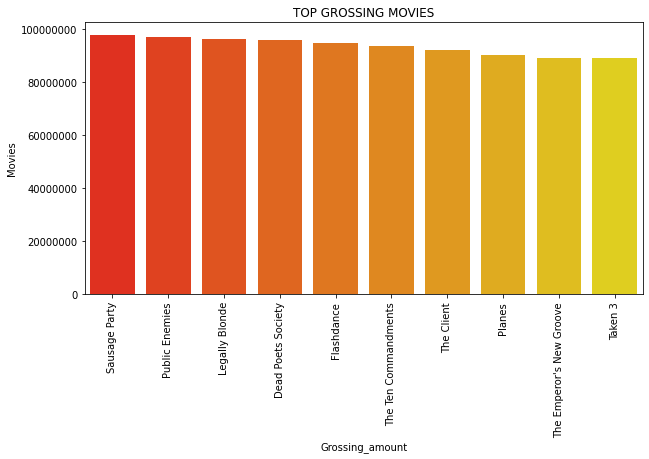

In [14]:
df['Gross']=df['Gross'].str.replace("$","").str.replace("M","")
df['New_Gross'] = pd.to_numeric(df['Gross'])
df['New_Gross']=df['New_Gross']*1000000
gross_amount = df['Gross'].sort_values(ascending=False).values[:10]
gross_amount = [float(i)*1000000 for i in gross_amount]
idx = df['Gross'].sort_values(ascending=False).index[:10]
movies=df.iloc[idx]['MOVIES']

plt.figure(figsize=(10,5))
sns.barplot(x=movies,y=gross_amount,palette="autumn")
plt.xlabel("Grossing_amount")
plt.ylabel("Movies")
plt.xticks(rotation=90)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title(label="TOP GROSSING MOVIES")

### 3.2 Voting recieved by all movies(top 10)

Text(0.5, 1.0, 'MOST VOTED MOVIES')

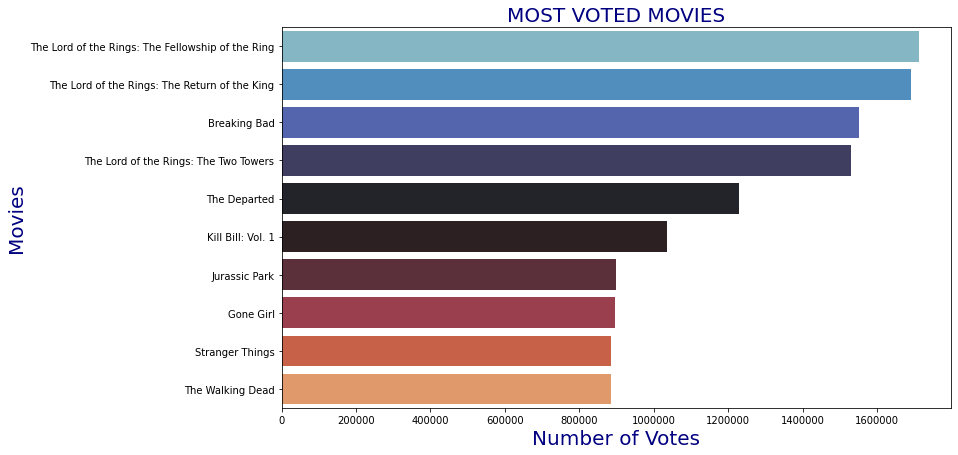

In [15]:
movies = df_cleaned.groupby("MOVIES")['VOTES'].sum().sort_values(ascending=False).reset_index(name="VOTES")[0:10]
plt.figure(figsize=(12,7))
font = {'color':  'navy',
        'weight': 'normal',
        'size': 20,
        }
sns.barplot(y='MOVIES',x='VOTES',data=movies,palette="icefire")
plt.ylabel("Movies",fontdict=font)
plt.xlabel("Number of Votes",fontdict=font)
plt.yticks(rotation=0)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title(label="MOST VOTED MOVIES",fontdict=font)

### 3.3 Which genre is most Popuular among viewers

In [16]:
## Counting the number of movies in which each genre is featured

from itertools import combinations
from collections import Counter

count=Counter()

for row in df_cleaned['GENRE']:
    row_split=row.split(",")
    count.update(Counter(combinations(row_split,1)))
genre_counter = count
genre_count = dict(count.most_common(10))

Text(0.5, 1.0, 'MOST POPULAR GENRE')

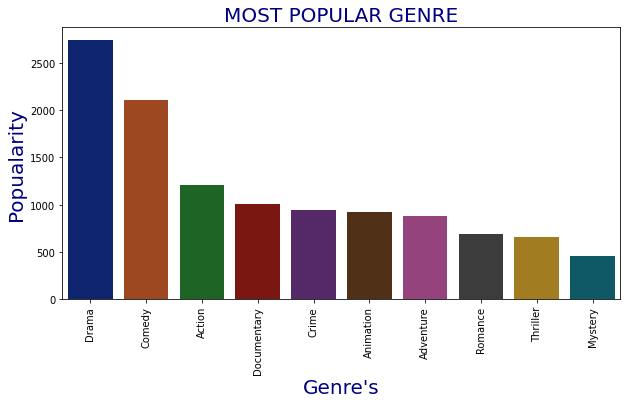

In [17]:
genres = list(genre_count.keys())
genres = [str(a).replace(",","").replace(")","").replace("(","").replace("'","") for a in genres]

count_of_genres = list(genre_count.values())


plt.figure(figsize=(10,5))
font = {'color':  'navy',
        'weight': 'normal',
        'size': 20,
        }

sns.barplot(x=genres,y=count_of_genres,palette="dark")
plt.xlabel("Genre's",
           fontdict=font)

plt.ylabel("Popualarity"
           ,fontdict=font)

plt.xticks(rotation=90)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.title(label="MOST POPULAR GENRE",fontdict=font)

In [18]:
genre_raw = df_cleaned['GENRE'].dropna().to_list()
genre_list = list()

for genres in genre_raw:
    genres = genres.split(",")
    for g in genres:
        genre_list.append(g)
        
genre_df = pd.DataFrame.from_dict(Counter(genre_list), orient = 'index').rename(columns = {0:'Count'})
genre_df.head()

,Count
Action,1210
Horror,417
Thriller,658
Animation,926
Adventure,882


In [19]:
fig = px.pie(data_frame = genre_df,
             values = 'Count',
             names = genre_df.index,
             color_discrete_sequence = px.colors.qualitative.Safe)

fig.update_traces(textposition = 'inside',
                  textinfo = 'label+percent',
                  pull = [0.05] * len(genre_df.index.to_list()))

fig.update_layout(title = {'text':'Genre Distribution'},
                  legend_title = 'Genre',
                  uniformtext_minsize=13,
                  uniformtext_mode='hide',
                  font = dict(
                      family = "Courier New, monospace",
                      size = 18,
                      color = 'black'
                  ))


fig.show()

### 3.4 Total Gross amount every year by the industry

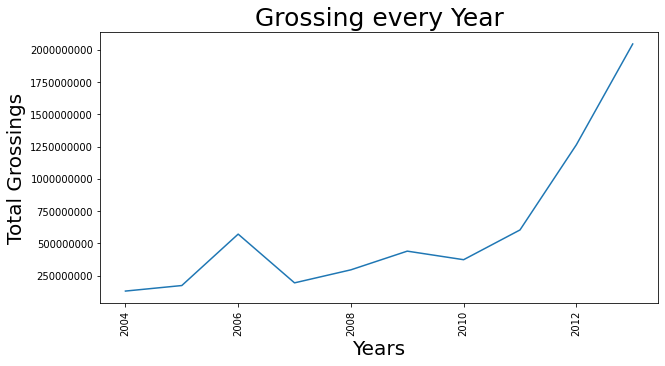

In [20]:
## Dropping irrelevent columns
df_cleaned = df.drop(["STARS",'YEAR', 'hypen_year', 'end_year'],axis=1)
df_cleaned.drop_duplicates("MOVIES",inplace=True)

df['beg_year']=df_cleaned["beg_year"].astype(int)
yearwise_earnings = df_cleaned.groupby('beg_year')['New_Gross'].sum().reset_index().sort_values("beg_year",ascending=False).reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x="beg_year",y="New_Gross",data=yearwise_earnings[10:20],palette="viridis")
plt.xlabel("Years",fontsize=20)
plt.ylabel("Total Grossings",fontsize=20)
plt.xticks(rotation=90)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title(label="Grossing every Year",fontsize="25")

plt.show()

### 3.5 Runtime of the movies (Top 10)

Text(0.5, 1.0, 'Movies with Most RunTime')

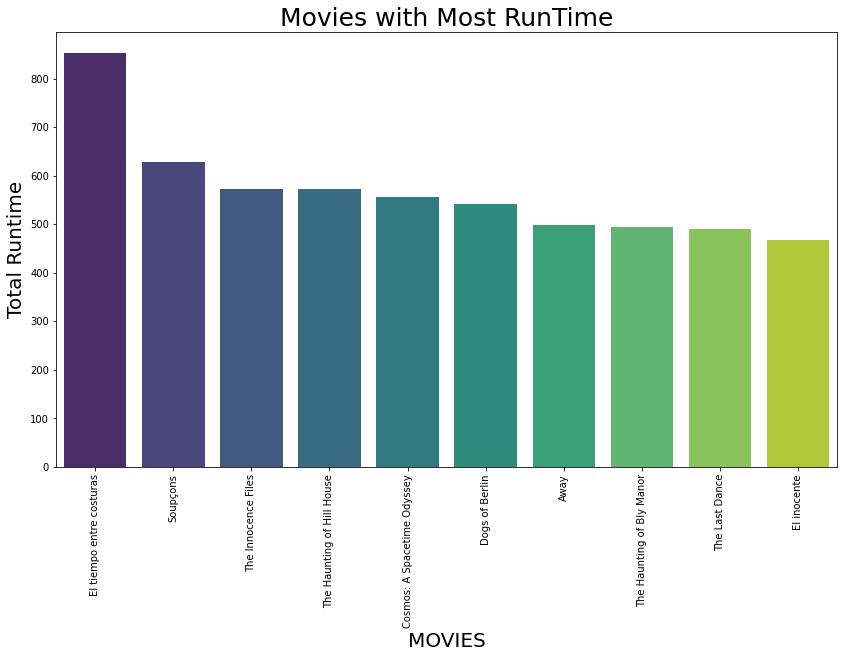

In [21]:
runtime_df=df_cleaned.groupby("MOVIES")['RunTime'].sum().sort_values(ascending=False).reset_index()[:10]
plt.figure(figsize=(14,8))
ax = sns.barplot(x="MOVIES",y="RunTime",data=runtime_df,palette="viridis")
plt.xlabel("MOVIES",fontsize=20)
plt.ylabel("Total Runtime",fontsize=20)
plt.xticks(rotation=90)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title(label="Movies with Most RunTime",fontsize="25")

### 3.6 Most Frequency of Rating

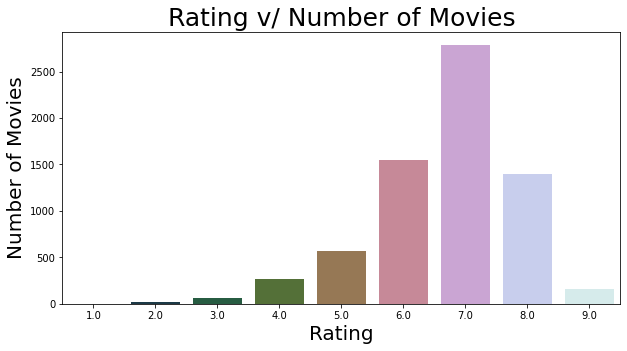

In [22]:
df_rating = df_cleaned.sort_values("RATING",ascending=False).reset_index()[["MOVIES","RATING"]]
df_rating["RATING"] = np.round(df_rating['RATING'])

df_rating = df_rating.groupby("RATING")['MOVIES'].count().reset_index().rename(columns={"MOVIES":"MOVIES_COUNT"})

plt.figure(figsize=(10,5))
sns.barplot(x="RATING",y="MOVIES_COUNT",data=df_rating,palette="cubehelix")
plt.xlabel("Rating",fontsize=20)
plt.ylabel("Number of Movies",fontsize=20)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title(label="Rating v/ Number of Movies",fontsize="25")

plt.show()

### 3.7 Most Popular actor

Text(0.5, 1.0, 'MOST POPULAR ACTOR')

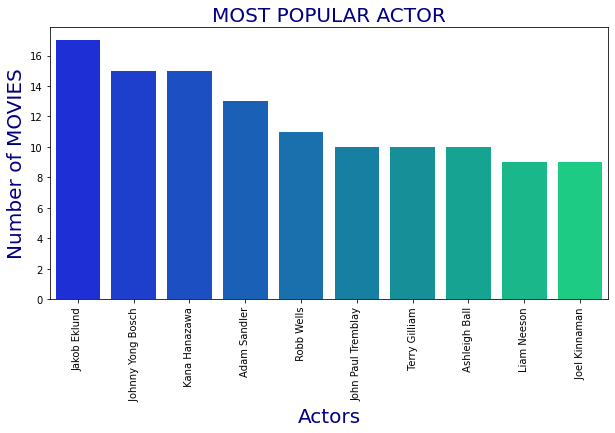

In [23]:
from itertools import combinations
from collections import Counter

count=Counter()

for row in df_cleaned['actors']:
    row_split=row.split(",")
    count.update(Counter(combinations(row_split,1)))
    
actors_count = dict(count.most_common(11))

count_of_actors = list(actors_count.values())[1:]

actors_count = list(actors_count.keys())
actors_count = [str(a).replace(",","").replace(")","").replace("(","").replace("'","") for a in actors_count][1:]

plt.figure(figsize=(10,5))
font = {'color':  'navy',
        'weight': 'normal',
        'size': 20,
        }

sns.barplot(x=actors_count,y=count_of_actors,palette="winter")
plt.xlabel("Actors",fontdict=font)
plt.ylabel("Number of MOVIES",fontdict=font)
plt.xticks(rotation=90)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title(label="MOST POPULAR ACTOR",fontdict=font)

In [24]:
temp_df= df_cleaned.sort_values("RATING",ascending=False)
temp_df =temp_df[temp_df["VOTES"]>5000].reset_index().iloc[:1000]
temp_df=temp_df[['MOVIES',"RATING","VOTES","GENRE"]]

## Counting the number of movies in which each genre is featured

from itertools import combinations
from collections import Counter

count=Counter()

for row in temp_df['GENRE']:
    row_split=row.split(",")
    count.update(Counter(combinations(row_split,1)))
    
count.most_common(10)

## To have a higher rating the most famous genres are drama,comdey,action and crime.

[(('Drama',), 603),
 (('Comedy',), 297),
 (('Crime',), 241),
 (('Action',), 223),
 (('Adventure',), 174),
 (('Animation',), 164),
 (('Mystery',), 109),
 (('Documentary',), 108),
 (('Romance',), 84),
 (('Thriller',), 79)]

## 4.Movie Recommendation System

In [25]:
# Features  using GENRE, RATING??, ONE-LINE, RunTime??, Director, Stars

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

features = ['GENRE','ONE-LINE','director','actors']

# Filling in missing values with Blank String
for feature in features:
    df_cleaned[feature] = df_cleaned[feature].fillna("")

df_cleaned['combined_features'] = df_cleaned['GENRE'] + " " + df_cleaned['ONE-LINE'] + " " + df_cleaned['director'] + " " + df_cleaned['actors'] 
cv = CountVectorizer()
count_matrix = cv.fit_transform(df_cleaned['combined_features'])
cosine_sim = cosine_similarity(count_matrix)

In [26]:
def movie_recommendation(mov,sim_num = 5):

    user_choice = mov
    
    try:
        ref_index = df_cleaned[df_cleaned['MOVIES'].str.contains(user_choice, case = False)].index[0]

        similar_movies = list(enumerate(cosine_sim[ref_index]))

        sorted_simmilar_movies = sorted(similar_movies, key = lambda x: x[1], reverse = True)[1:]

        print('\nRecomended Movies for [{}]'.format(user_choice))
        print('-'*(24 + len(user_choice)))

        for i, element in enumerate(sorted_simmilar_movies):
            similar_movie_id = element[0]
            similar_movie_title = df_cleaned['MOVIES'].iloc[similar_movie_id]
            s_score = element[1]
            print('{:40} -> {:.3f}'.format(similar_movie_title, s_score))

            if i > sim_num:
                break
    except IndexError:
        print("\n[{}] is not in our database!".format(user_choice))
        print("We couldn't recommend anyting...Sorry...")

In [27]:
movie_recommendation("spider",sim_num=10)


Recomended Movies for [spider]
------------------------------
Batman v Superman: Dawn of Justice       -> 0.313
Quantum Quest: A Cassini Space Odyssey   -> 0.309
Kong: Skull Island                       -> 0.305
Liu lang di qiu                          -> 0.300
Jumanji: The Next Level                  -> 0.293
Jupiter's Legacy                         -> 0.290
The Division                             -> 0.288
The Hitman's Bodyguard                   -> 0.286
Mercenaire                               -> 0.281
Afro Samurai                             -> 0.280
The Witcher: Blood Origin                -> 0.278
Family Leave                             -> 0.274
